In [136]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity
from scipy.ndimage import shift as nd_shift
from skimage.registration import phase_cross_correlation

In [137]:
def extract_signal(img):
    # Усредняем по вертикали 
    signal = np.mean(img, axis=0)  # shape (200,)
    return signal

In [138]:
dataset_dir = r"C:\Users\valekseeva\Documents\Algorithms\Subpixel-Processing\Datasets\Distorted_.png"

# Ожидаемые типы
distortion_types = ["blur", "noise", "scratch", "lighting", "combined", "noise_scratch_blur", "spot"]

# Группировка файлов
all_sequences = {}

for dtype in distortion_types:
    files = [f for f in os.listdir(dataset_dir) if f.endswith(".png") and f"_{dtype}_" in f]
    files.sort()
    print(f"Type {dtype}: {len(files)} files found")

    
    # Загрузка
    images = []
    for f in files:
        path = os.path.join(dataset_dir, f)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        if img.shape != (4, 200):
            img = cv2.resize(img, (200, 4))
        images.append(img.astype(np.float32) / 255.0)

    all_sequences[dtype] = np.array(images)
    print(f"Loaded type: {dtype} {all_sequences[dtype].shape}")

Type blur: 100 files found
Loaded type: blur (100, 4, 200)
Type noise: 100 files found
Loaded type: noise (100, 4, 200)
Type scratch: 100 files found
Loaded type: scratch (100, 4, 200)
Type lighting: 50 files found
Loaded type: lighting (50, 4, 200)
Type combined: 50 files found
Loaded type: combined (50, 4, 200)
Type noise_scratch_blur: 50 files found
Loaded type: noise_scratch_blur (50, 4, 200)
Type spot: 50 files found
Loaded type: spot (50, 4, 200)


Алгоритм 1: Абсолютное позиционирование на основе анализа одного кадра

Шкала имеет период 20 пикселей (line_width=10, gap_width=10).

Оценим фазу внутри периода с помощью взаимной корреляции с эталонным периодом.

In [139]:
def algorithm_1(img, period=20):
    """
    Оценивает положение по одному изображению.
    Возвращает: грубое положение (int), фаза (float)
    """
    # Создаём эталонный период (10 пикселей линии + 10 пикселей промежутка)
    ref_period = np.zeros(period)
    ref_period[:10] = 1.0  
    
    # Для устойчивости используем среднюю строку 
    signal = np.mean(img, axis=0)  # shape (200,)
    
    # Оценка фазы через взаимную корреляцию
    # Используем только первую строку (или среднюю) для 1D-анализа
    corr = np.correlate(signal, ref_period, mode='full')
    max_idx = np.argmax(corr)
    phase = (max_idx - len(ref_period) + 1) % period  # Сдвиг в пределах периода
    
    # Грубое положение неизвестно без кодирования, поэтому используем оценку по смещению от начала
    # В реальном энкодере здесь был бы ECC, здесь простая эвристика
    coarse_pos = 0 
    
    return coarse_pos, phase / period 

Алгоритм 2: Экстраполяция из истории

In [140]:
def algorithm_2(history, dt=62.5e-6):
    """
    Линейная экстраполяция на основе двух последних измерений.
    history: список [(time, position), ...]
    Возвращает: грубое положение (int), фаза (float)
    """
    if len(history) < 2:
        if history:
            pos = history[-1]['position'] 
        else:
            pos = 0.0
    else:
        p1 = history[-2]['position'] 
        p2 = history[-1]['position'] 
        # Истинное движение = +1.0 px/frame
        velocity = 1.0
        # Экстраполяция на момент t2 + dt
        pos = p2 + velocity * dt
    
    coarse = int(pos // 20) 
    phase = (pos % 20) / 20.0
    return coarse, phase

Основной цикл: сравнение и флаг ошибки

In [141]:
# Инициализация
results = {}

for dtype, images in all_sequences.items():
    history = []
    error_flags = []
    positions = []
    
    for i, img in enumerate(images):
        # Алгоритм 1
        coarse1, phase1 = algorithm_1(img, period=20)
        
        # Алгоритм 2
        coarse2, phase2 = algorithm_2(history, dt=62.5e-6)
        
        # Сравнение
        if abs(coarse1 - coarse2) <= 1:
            output_coarse = coarse1
            error_counter = 0
        else:
            output_coarse = coarse2
            if history:
                error_counter = history[-1]['error_counter'] + 1
            else:
                error_counter = 1
        
        error_flag = error_counter > 4
        final_position = output_coarse * 20 + phase1 * 20
        
        history.append({
            'time': i * 62.5e-6,
            'position': final_position,
            'coarse1': coarse1,
            'coarse2': coarse2,
            'error_counter': error_counter,
            'error_flag': error_flag
        })
        
        positions.append(final_position)
        error_flags.append(error_flag)
    
    results[dtype] = {
        'images': images,
        'history': history,
        'positions': np.array(positions),
        'error_flags': np.array(error_flags)
    }
    
    # Вывод количества ошибок
    num_errors = np.sum(error_flags)
    print("Error flags at steps:", [i for i, f in enumerate(error_flags) if f])

Error flags at steps: []
Error flags at steps: []
Error flags at steps: []
Error flags at steps: []
Error flags at steps: []
Error flags at steps: []
Error flags at steps: []


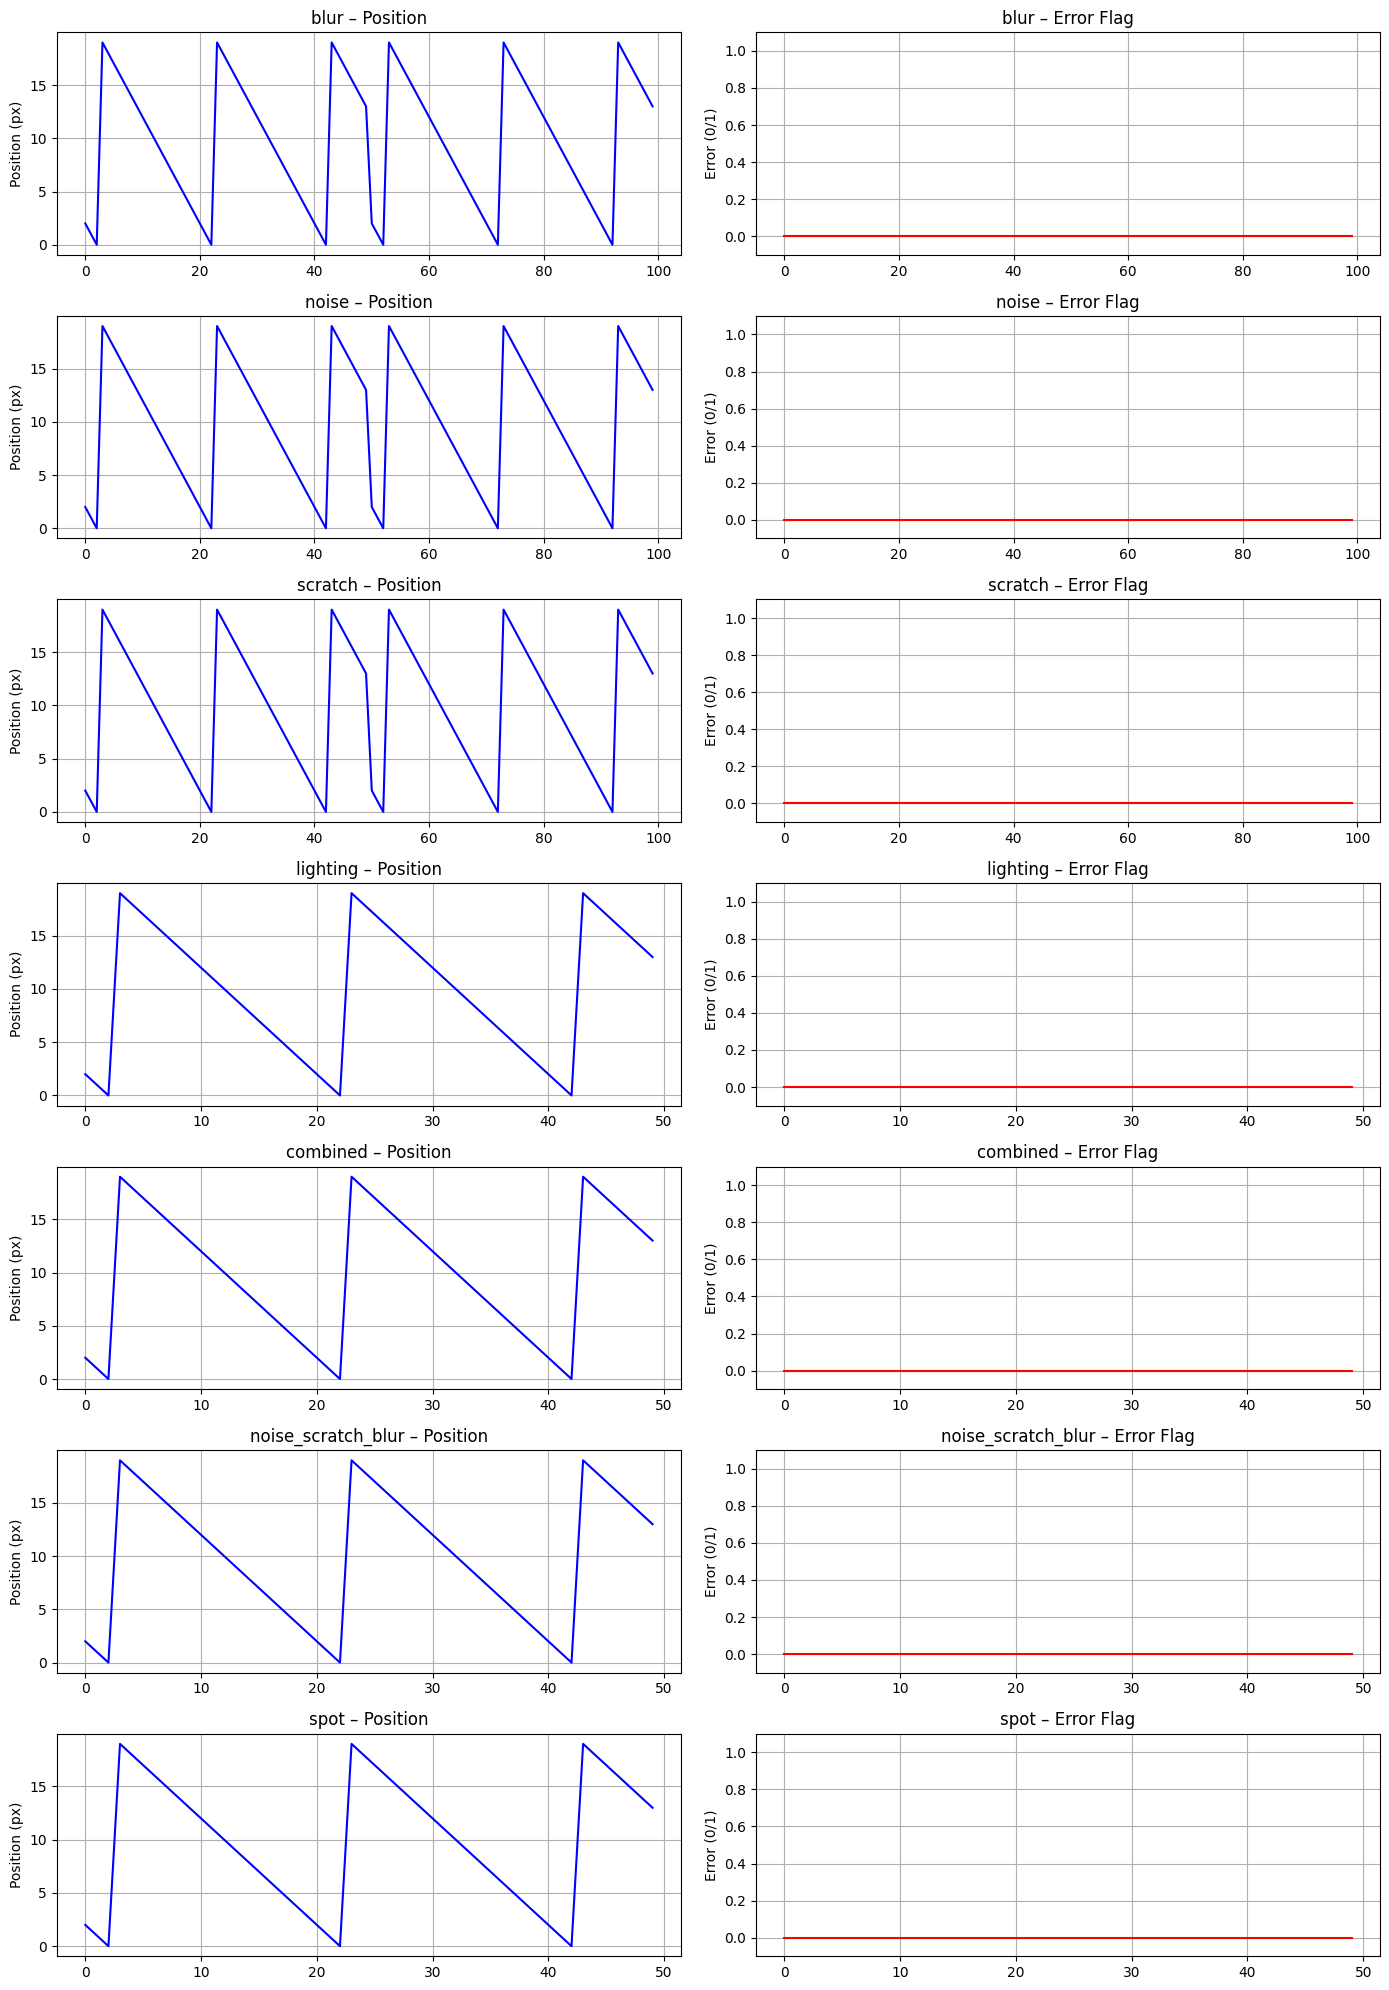

In [142]:
fig, axes = plt.subplots(7, 2, figsize=(14, 20))

for i, dtype in enumerate(distortion_types):
    if dtype not in results:
        continue
        
    pos = results[dtype]['positions']
    err = results[dtype]['error_flags']
    
    # Положение
    axes[i, 0].plot(pos, 'b-')
    axes[i, 0].set_title(f'{dtype} – Position')
    axes[i, 0].set_ylabel('Position (px)')
    axes[i, 0].grid(True)
    
    # Флаг ошибки
    axes[i, 1].plot(err, 'r-', drawstyle='steps-mid')
    axes[i, 1].set_title(f'{dtype} – Error Flag')
    axes[i, 1].set_ylabel('Error (0/1)')
    axes[i, 1].set_ylim(-0.1, 1.1)
    axes[i, 1].grid(True)

plt.tight_layout()
plt.show()


Visualization: blur


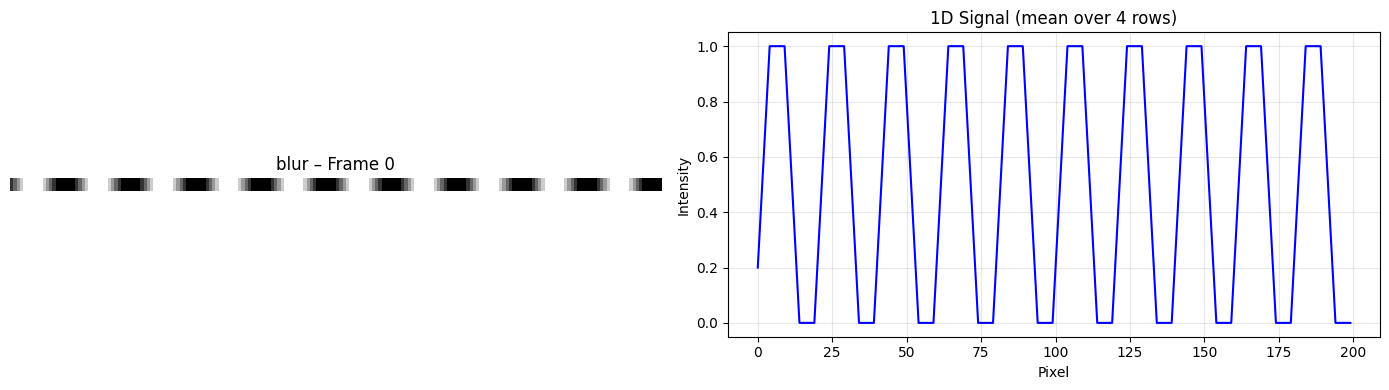

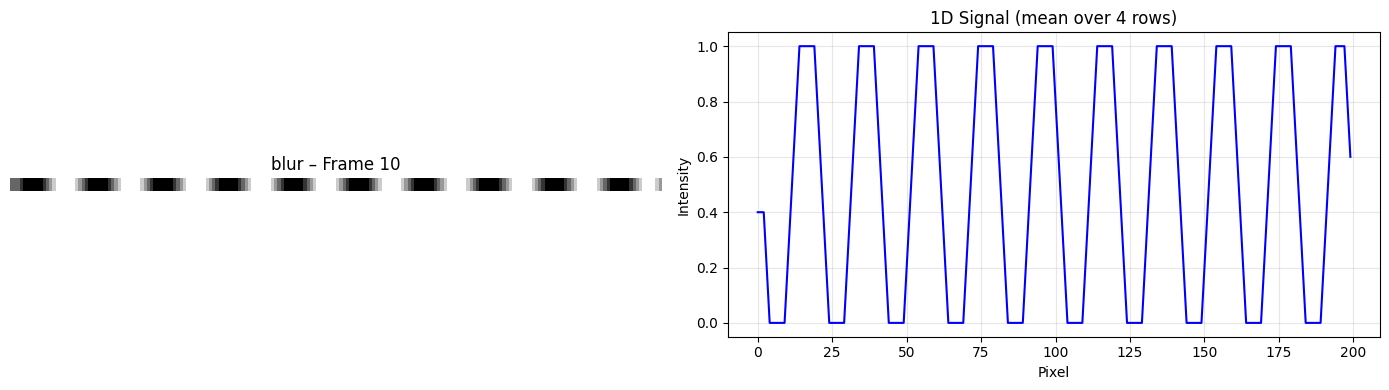

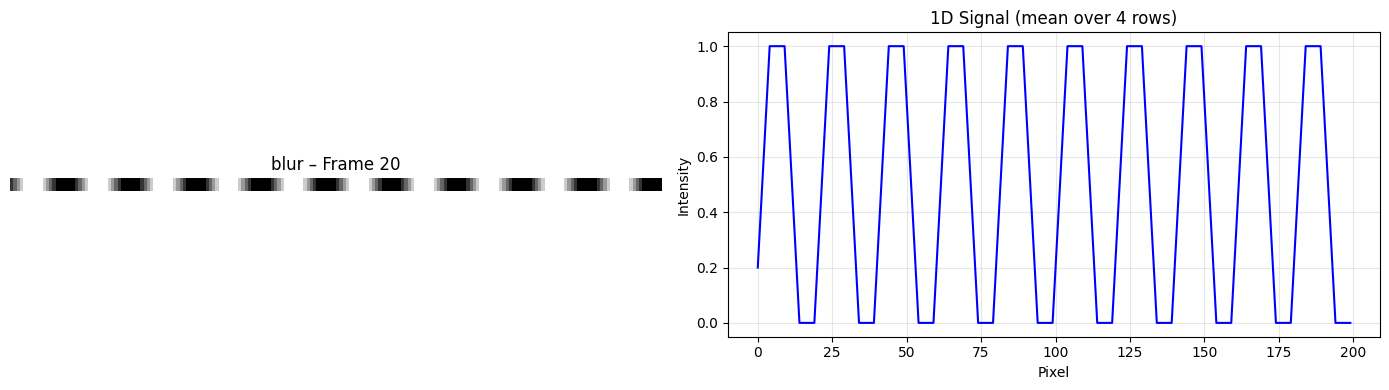

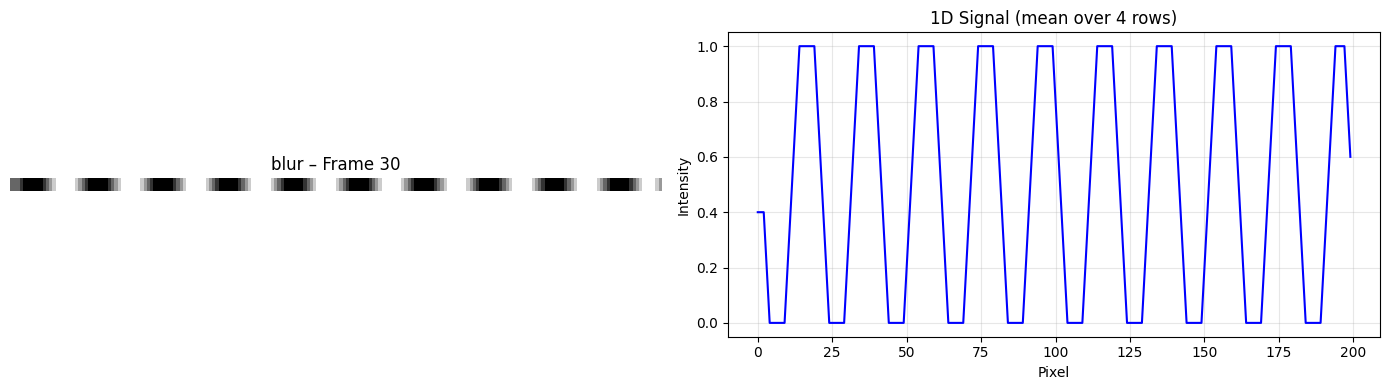

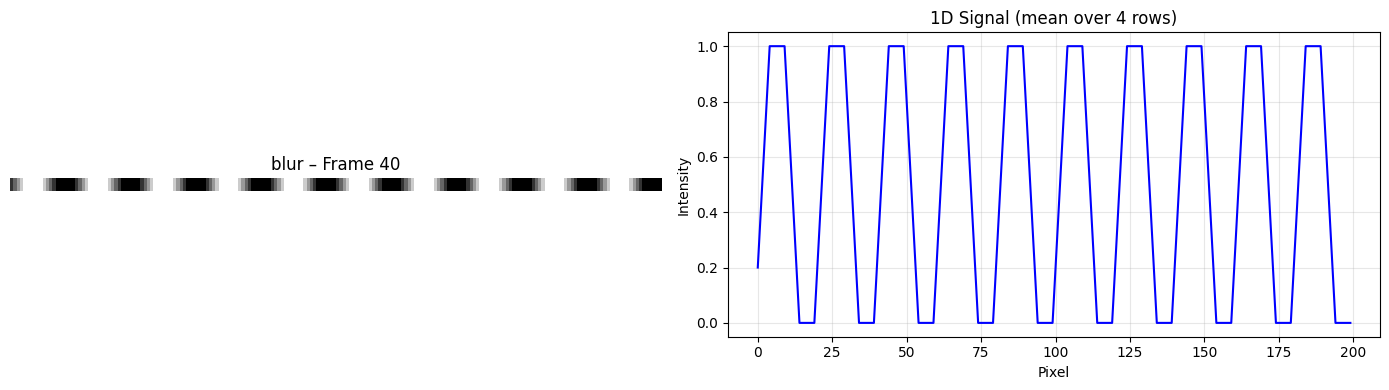


Visualization: noise


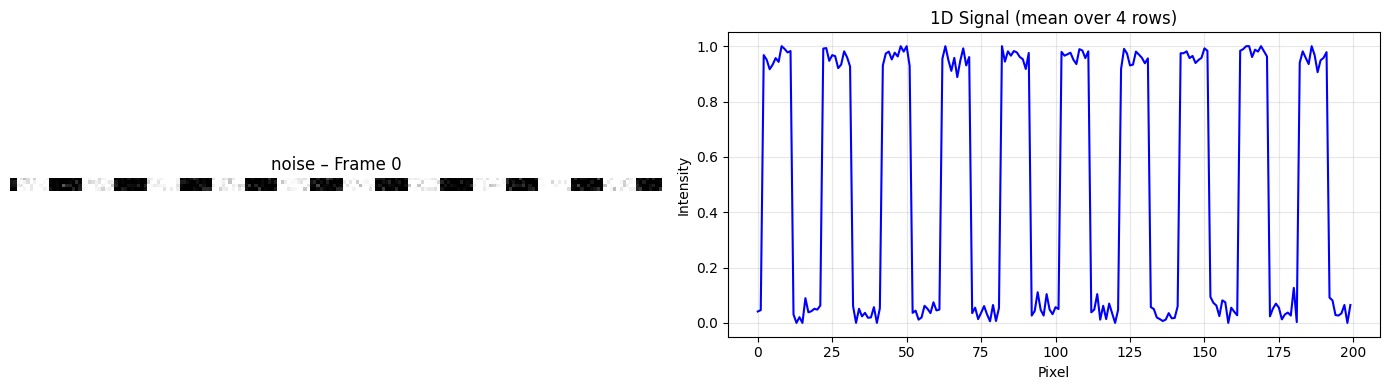

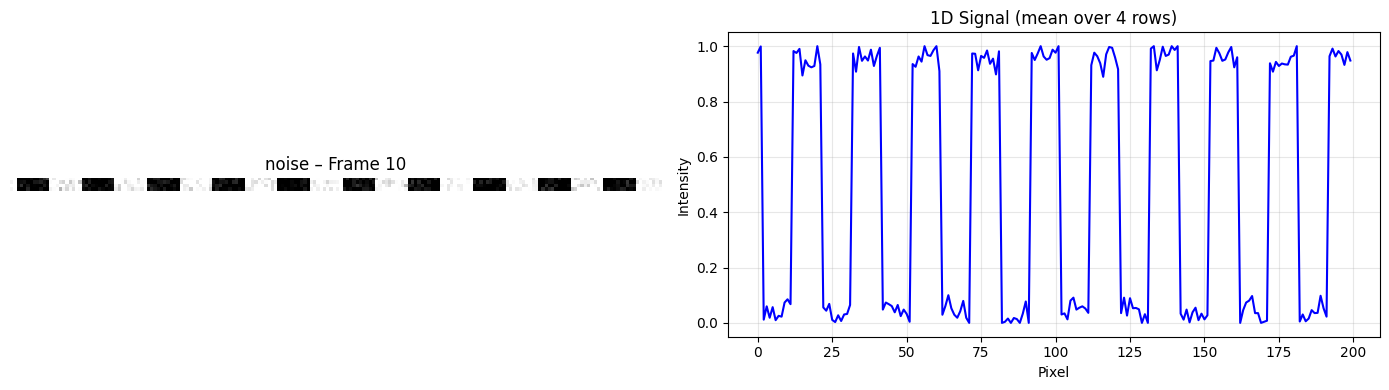

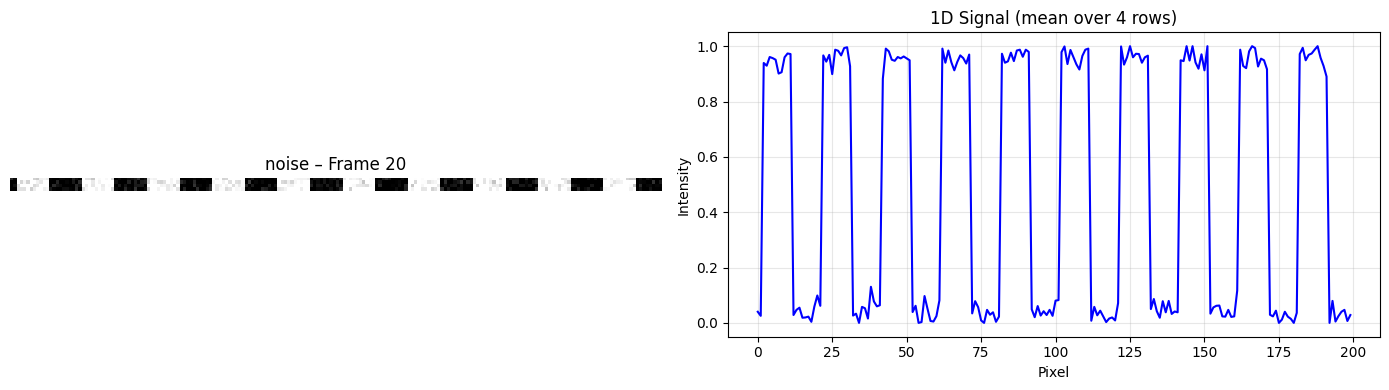

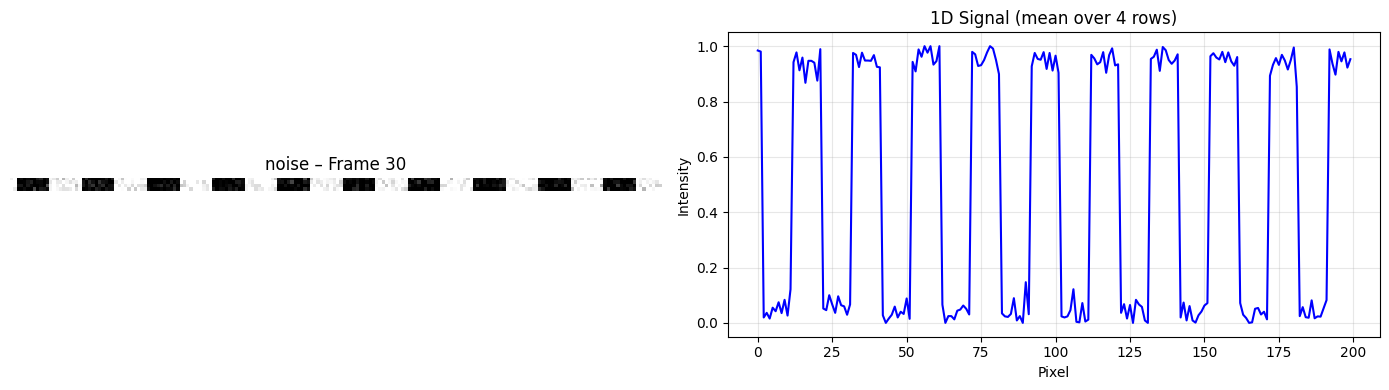

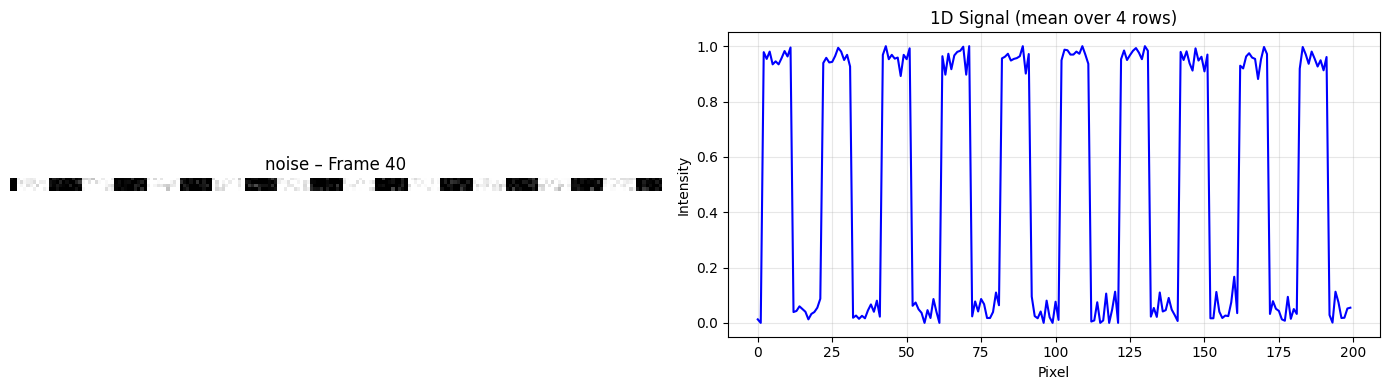


Visualization: scratch


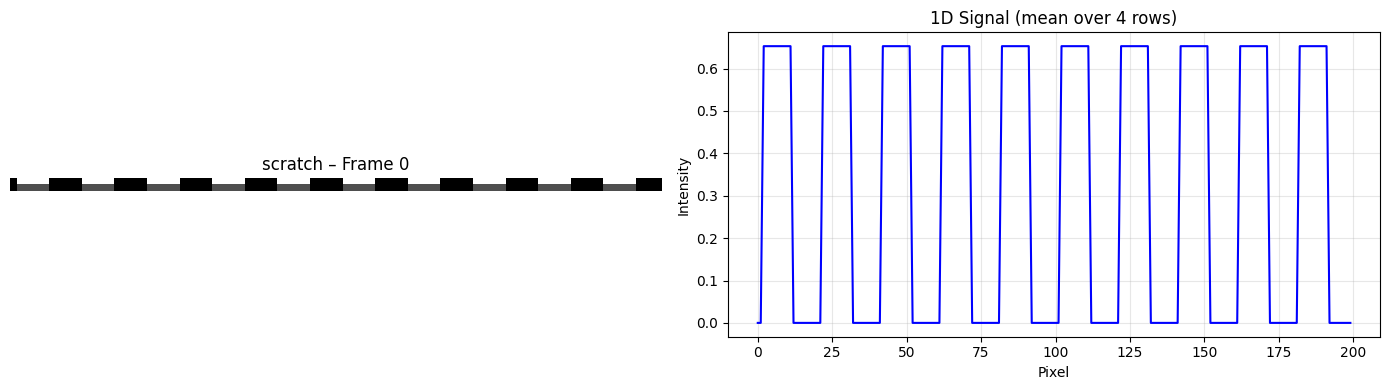

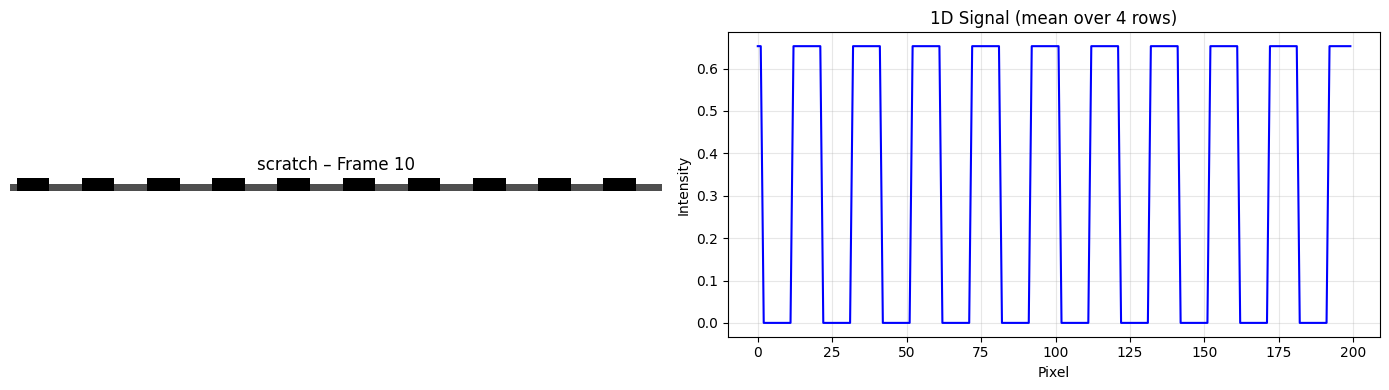

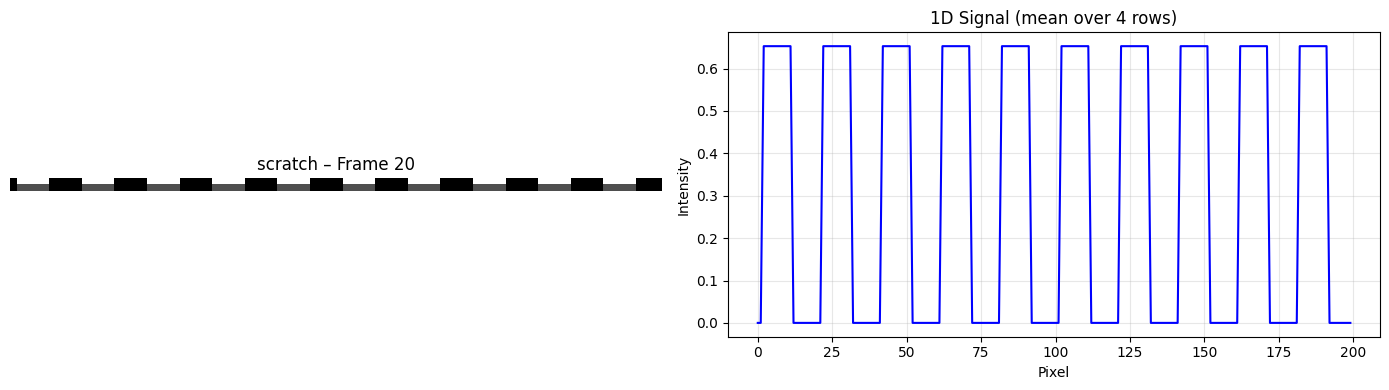

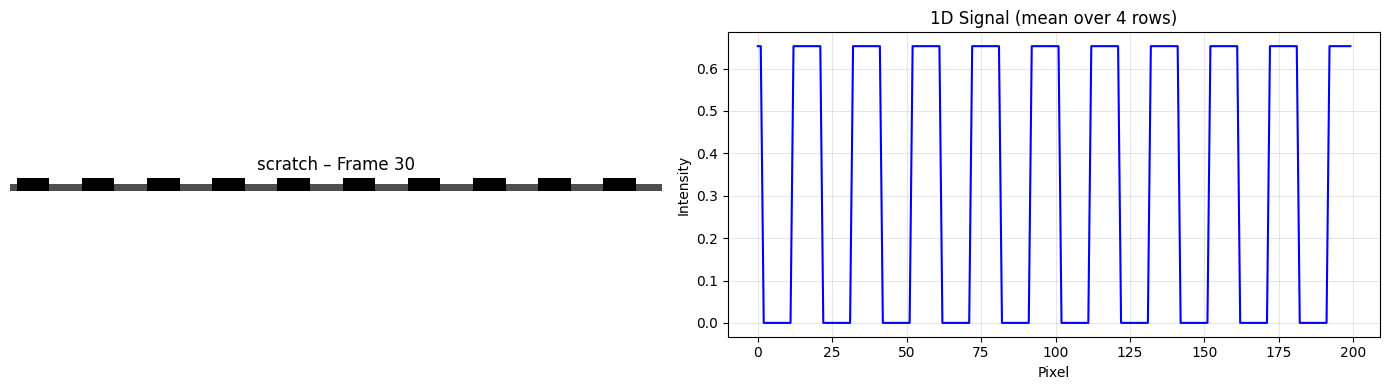

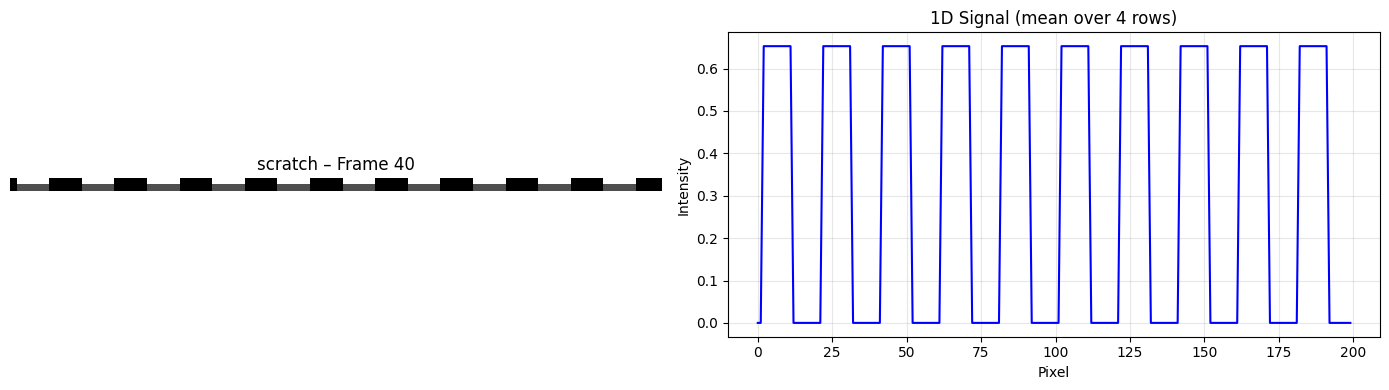


Visualization: lighting


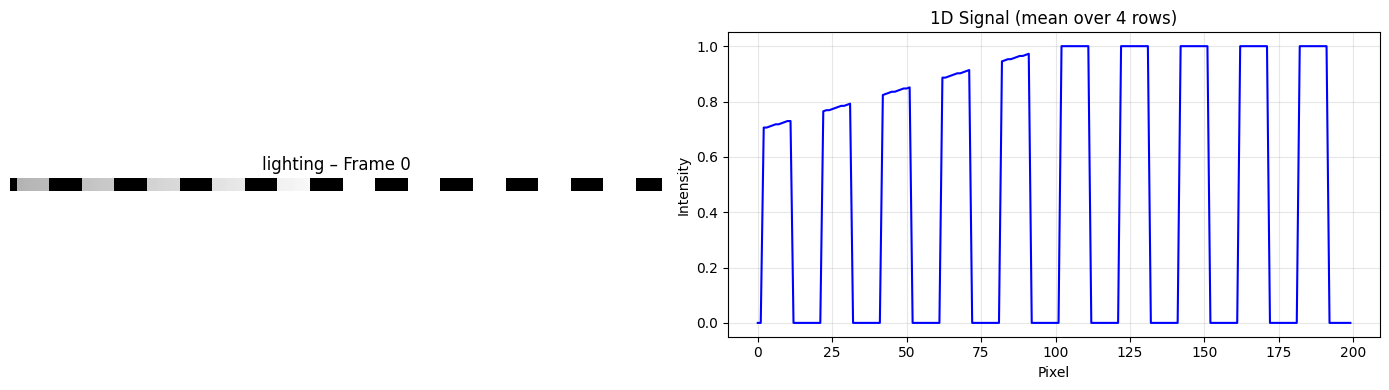

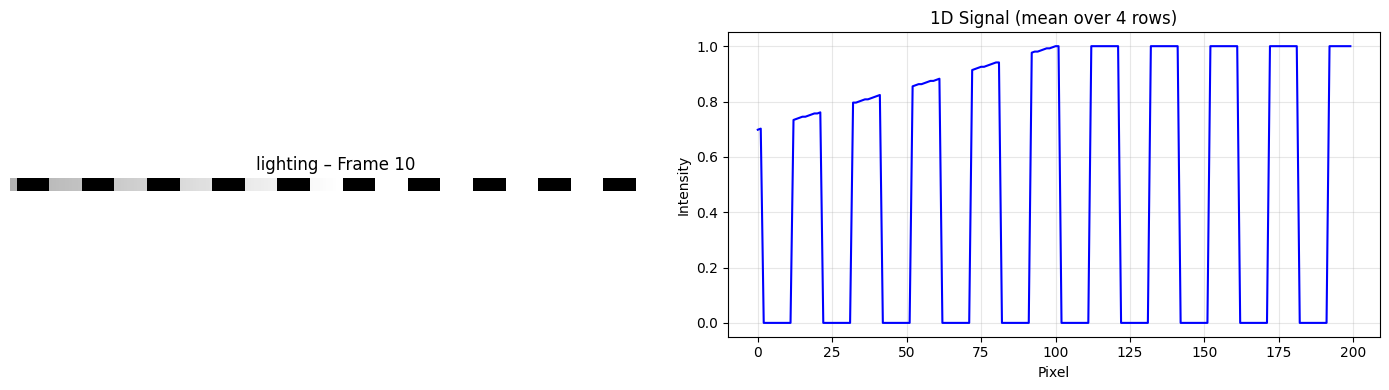

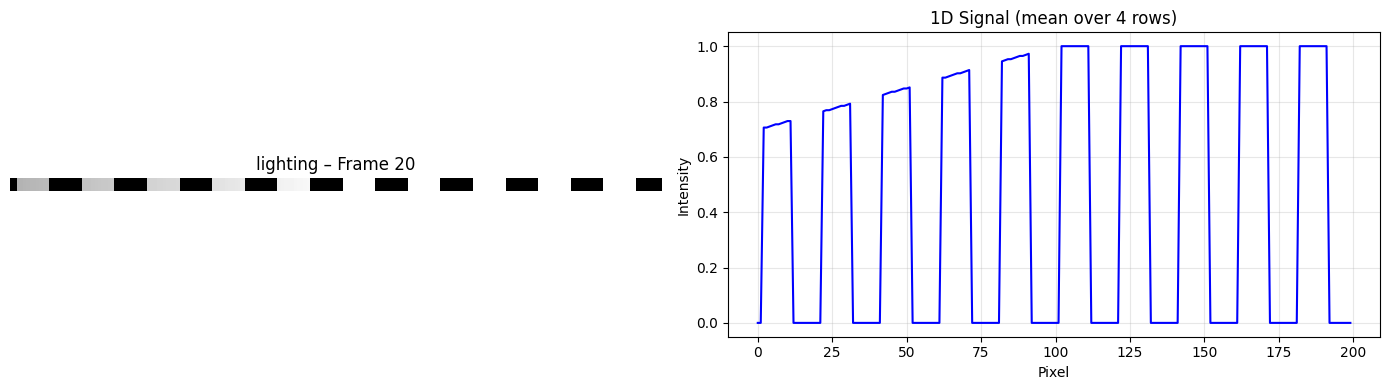

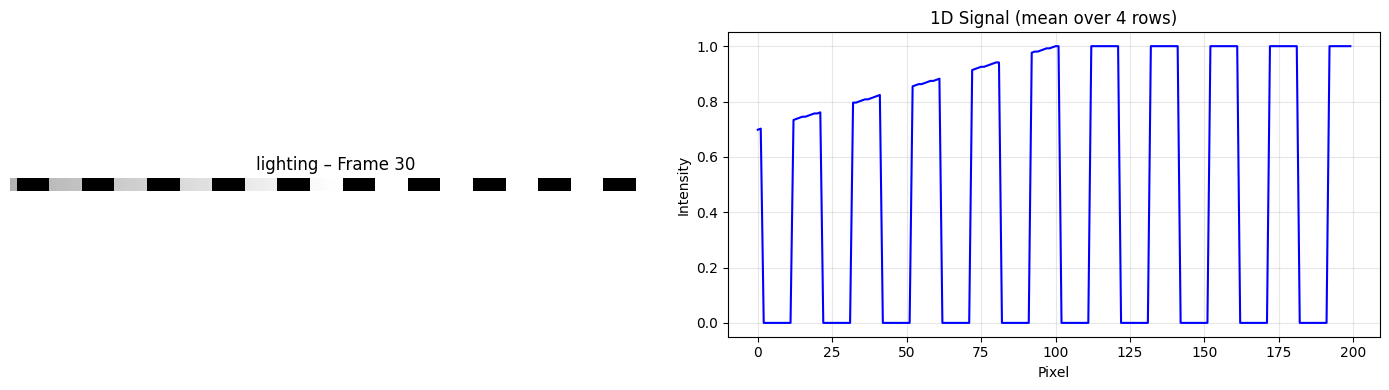

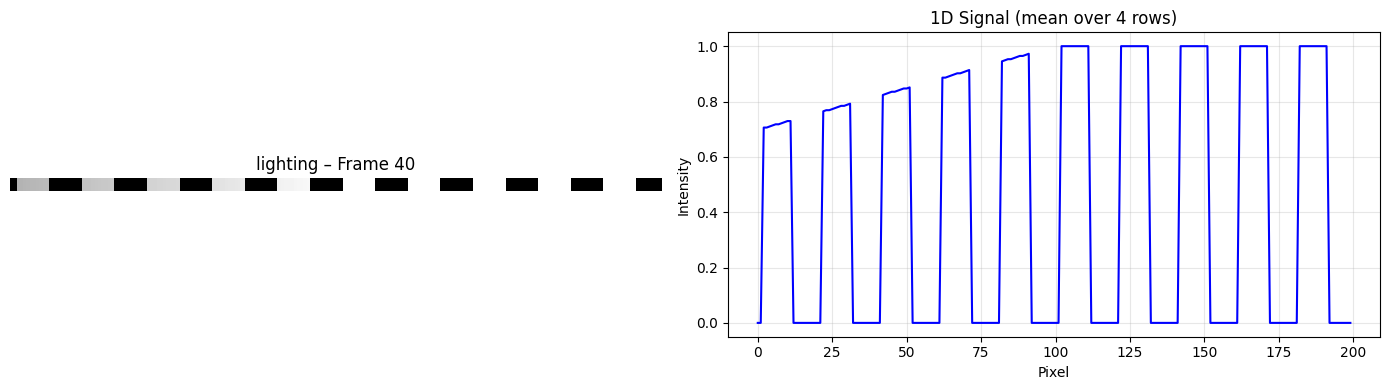


Visualization: combined


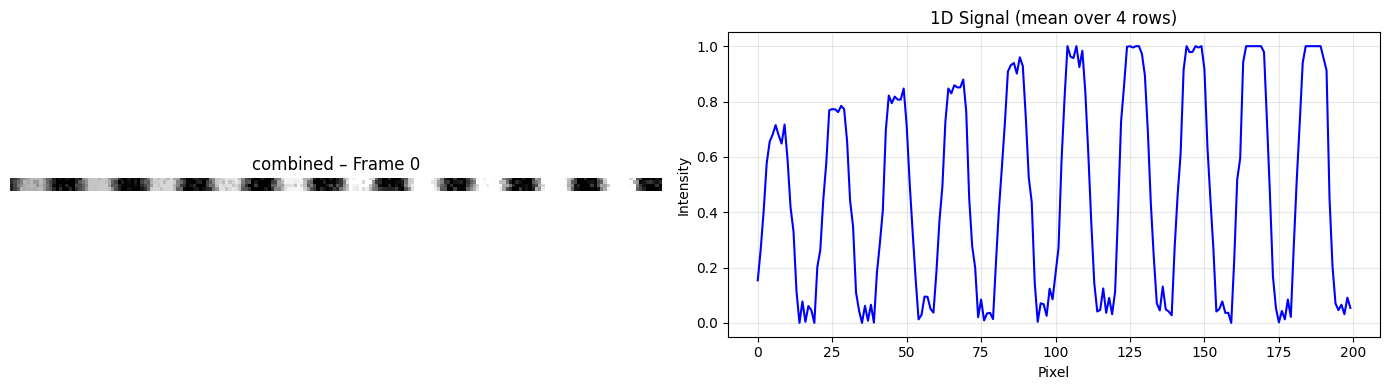

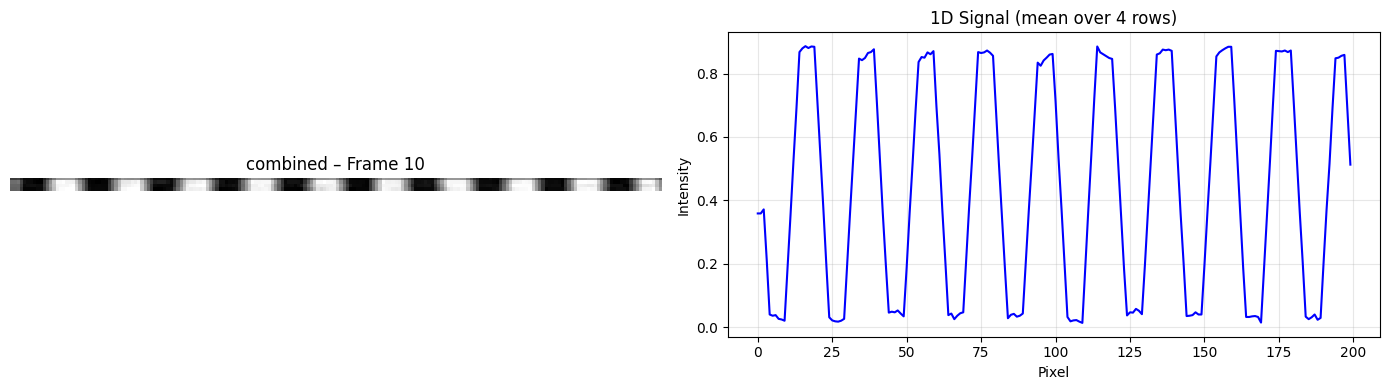

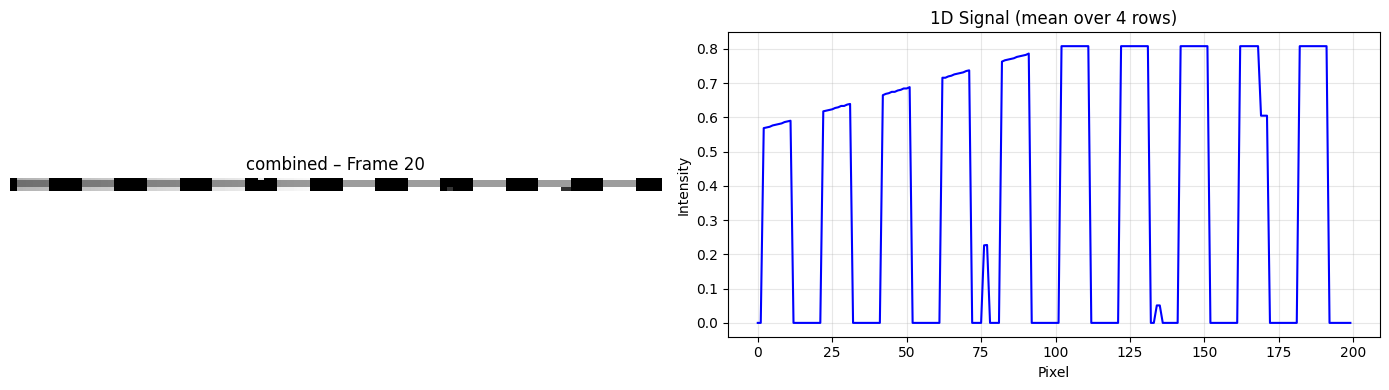

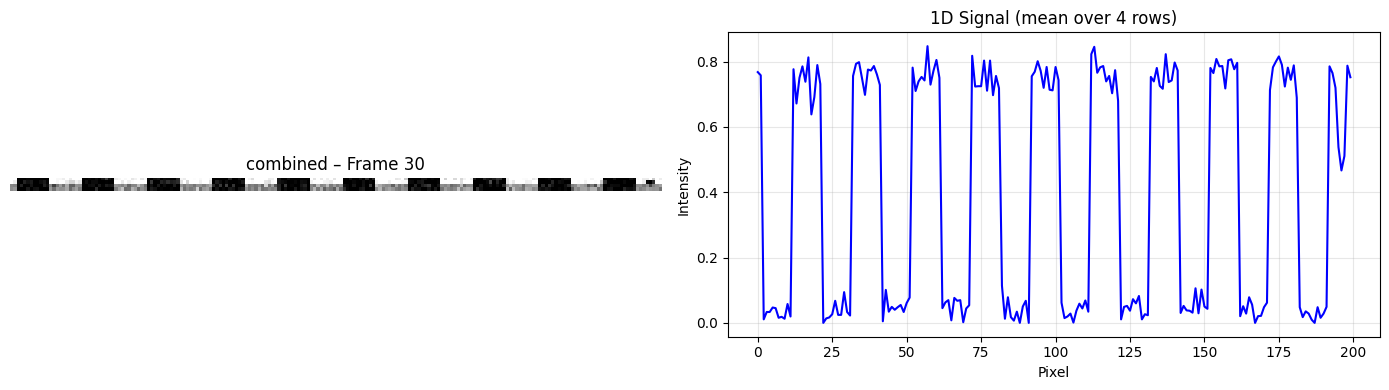

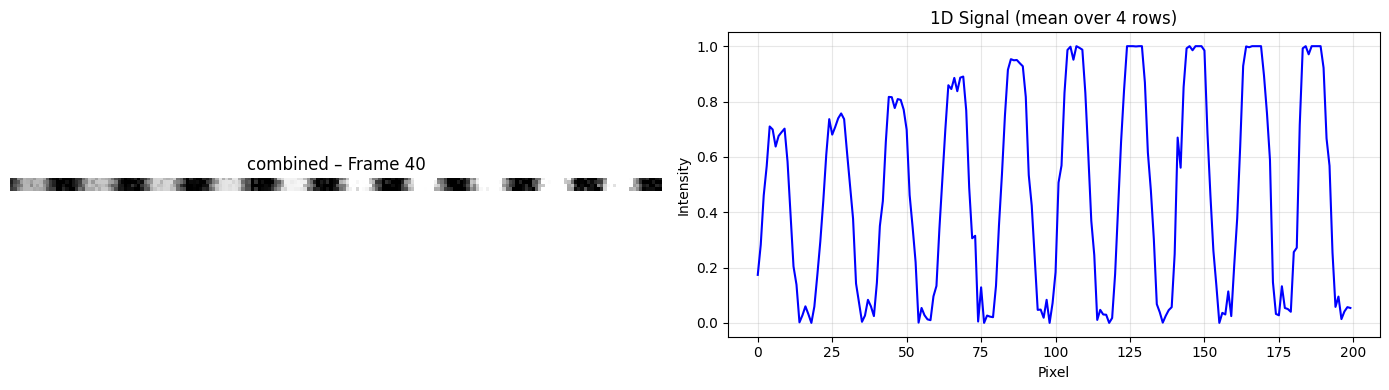


Visualization: noise_scratch_blur


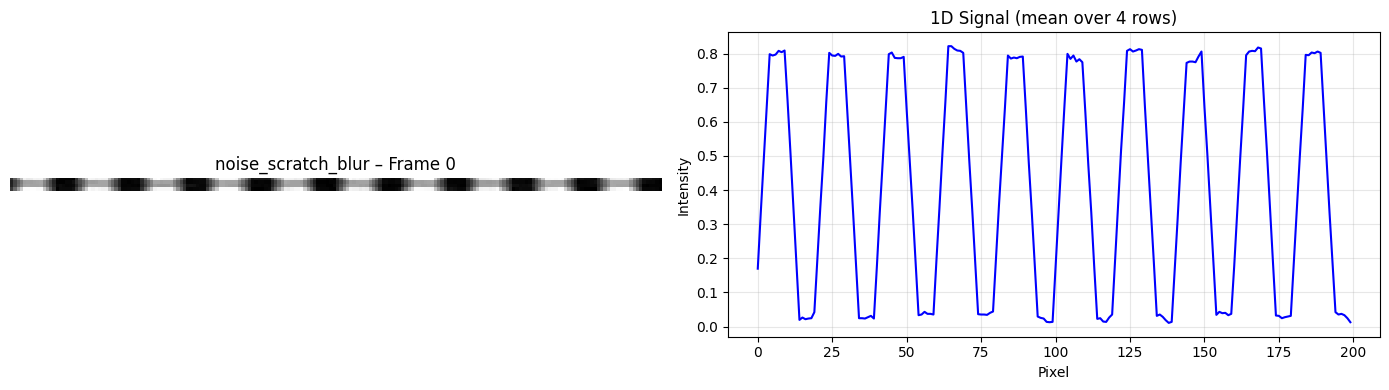

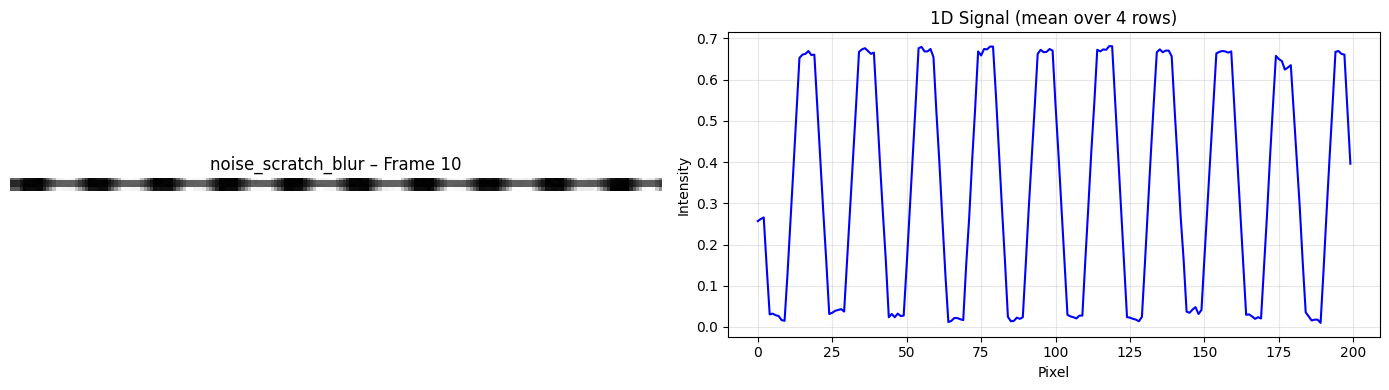

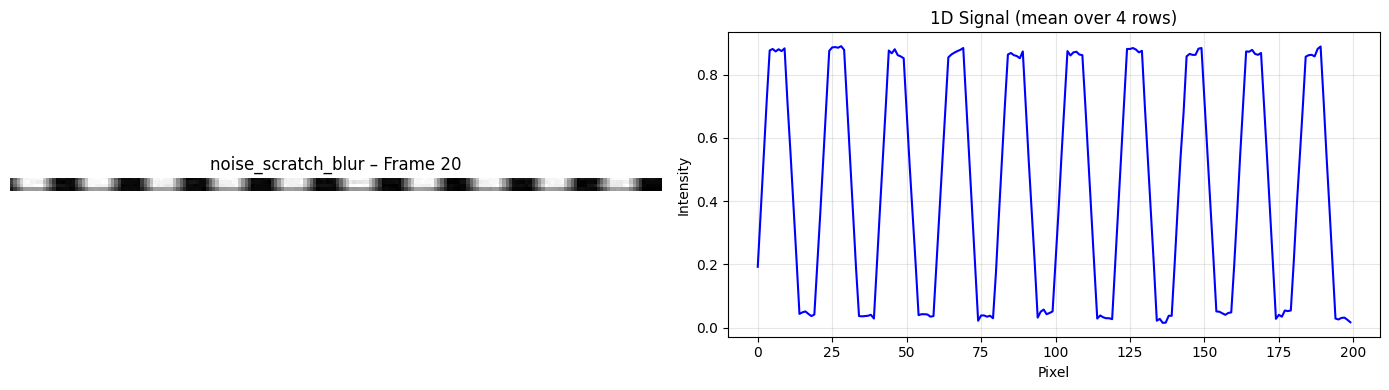

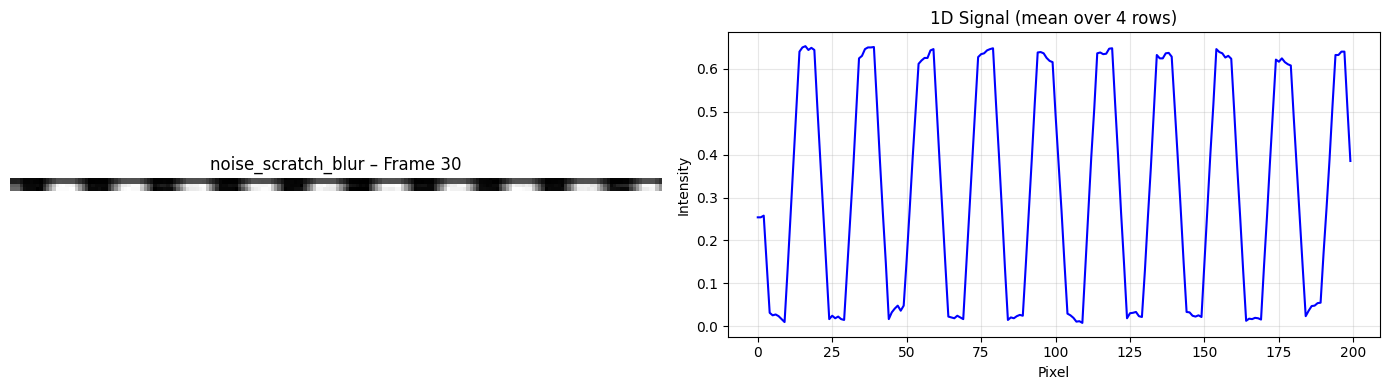

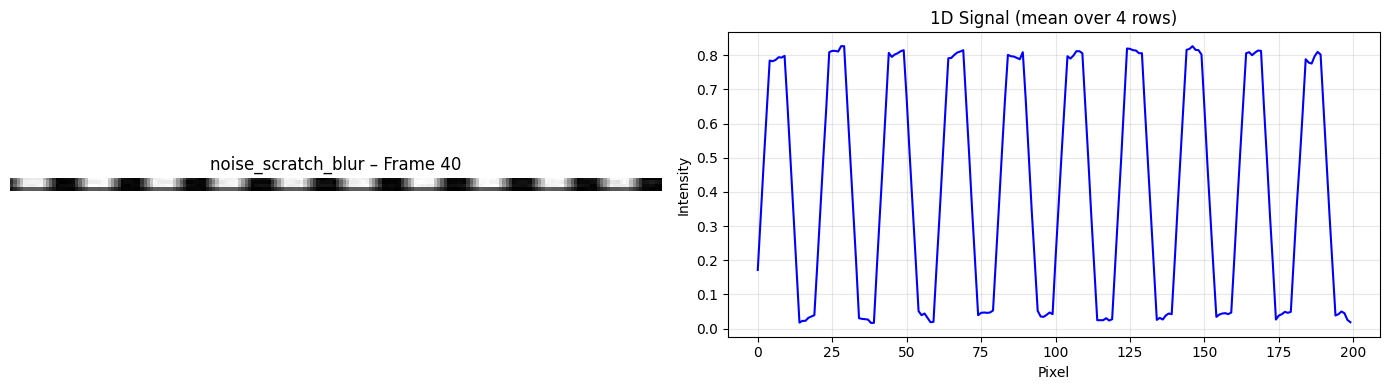


Visualization: spot


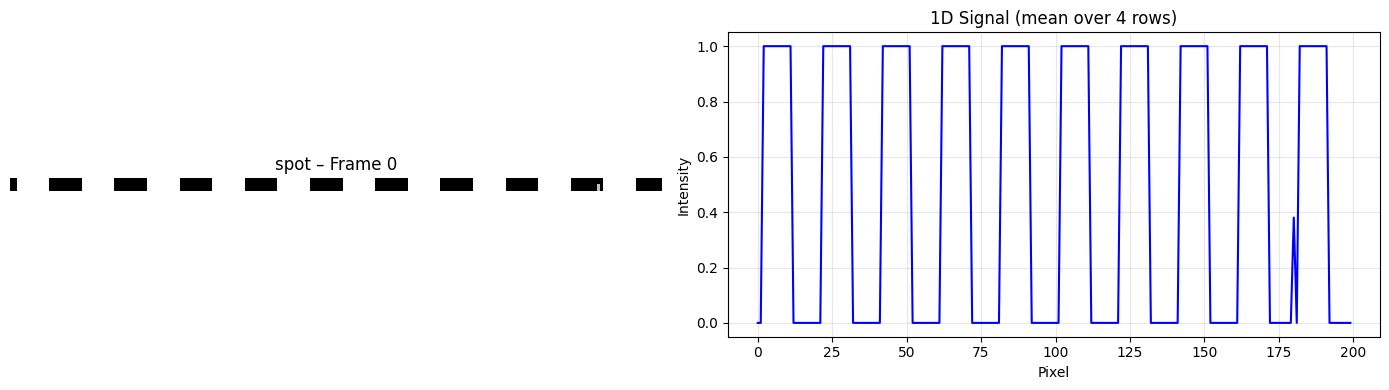

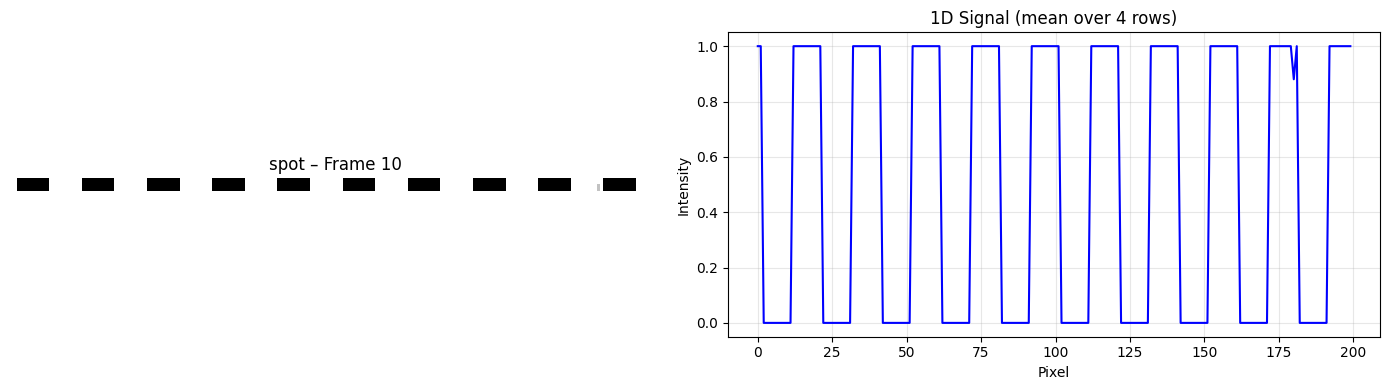

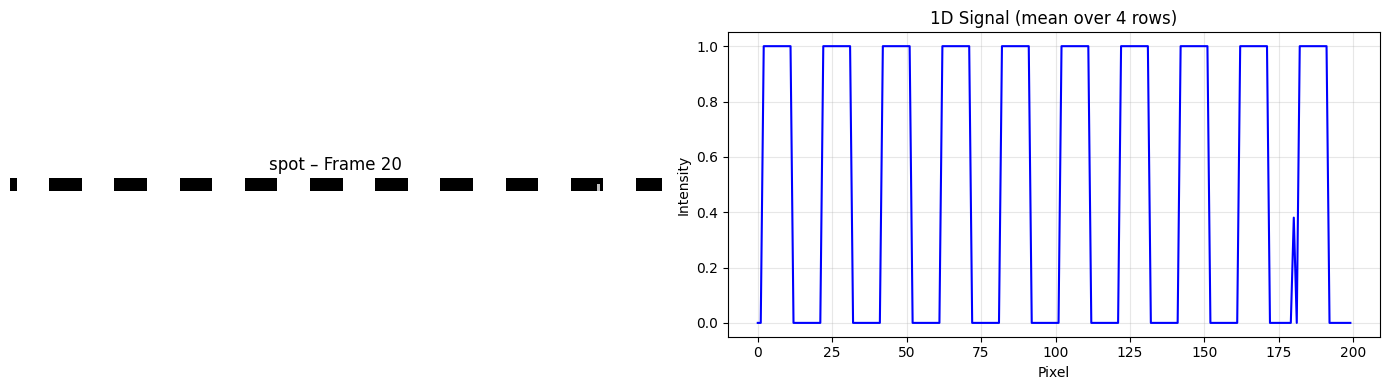

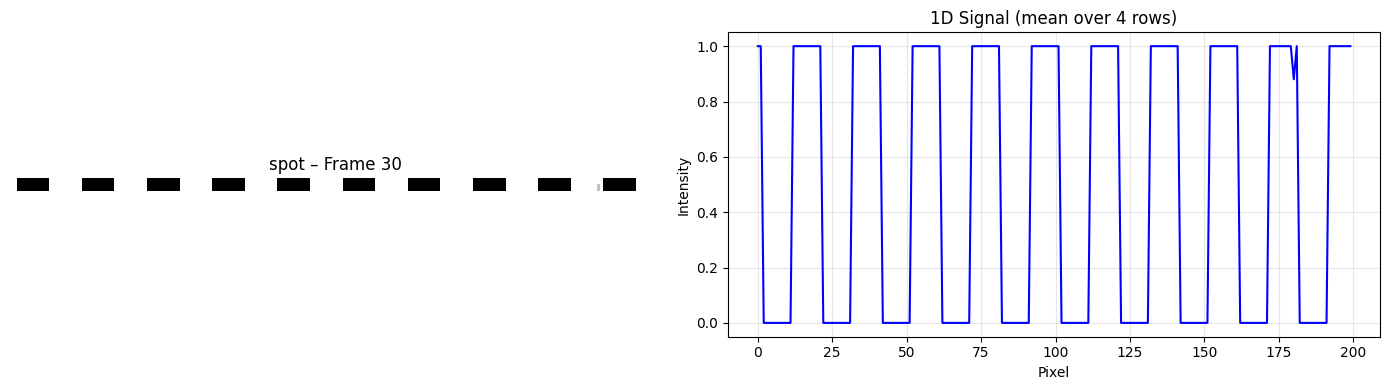

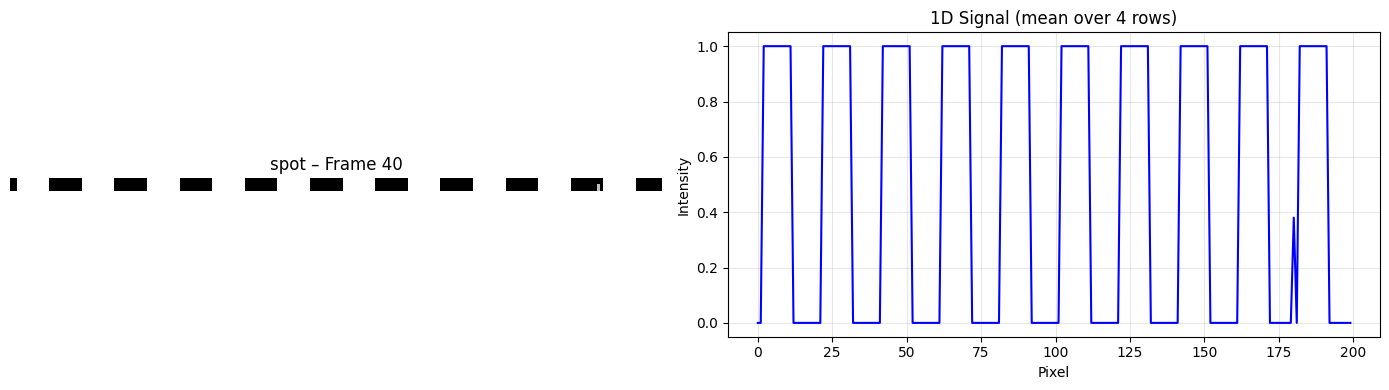

In [143]:
example_indices = [0, 10, 20, 30, 40]

for dtype in distortion_types:
    if dtype not in results:
        continue
        
    print(f"\nVisualization: {dtype}")
    images = results[dtype]['images']
    history = results[dtype]['history']
    
    for idx in example_indices:
        img = images[idx]
        signal = extract_signal(img)
        coarse1 = history[idx]['coarse1']
        coarse2 = history[idx]['coarse2']
        error_flag = history[idx]['error_flag']
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        
        # 2D изображение
        axes[0].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[0].set_title(f'{dtype} – Frame {idx}')
        axes[0].axis('off')
        
        # 1D сигнал
        axes[1].plot(signal, 'b-', linewidth=1.5)
        axes[1].set_title('1D Signal (mean over 4 rows)')
        axes[1].set_xlabel('Pixel')
        axes[1].set_ylabel('Intensity')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()